**D3APL: Aplicações em Ciência de Dados** <br/>
IFSP Campinas

Prof. Dr. Samuel Martins (Samuka) <br/><br/>

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

# Training our first CNN for Multiclass Image Classification

## 1. Set up

#### 1.1 TensorFlow + Keras

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.8.0'

**GPU available?**

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### 1.2 Fixing the seed for reproducibility (optional)
That's a try for reprodubility in Keras. See more on:
- https://stackoverflow.com/a/59076062
- https://machinelearningmastery.com/reproducible-results-neural-networks-keras/

In [4]:
import os
import tensorflow as tf
import numpy as np
import random

def reset_random_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    
# make some random data
reset_random_seeds()

#### 1.3 Other imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt

#### 1.4 CIFAR-10
https://keras.io/api/datasets/cifar10/ <br/>
https://en.wikipedia.org/wiki/CIFAR-10

In [6]:
from tensorflow.keras.datasets import cifar10

In [7]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

The dataset is already split into a training set and a test set.

In [8]:
# download done in folder: "~/.keras/datasets"
import os
os.listdir(os.path.expanduser('~/.keras/datasets'))

['fashion-mnist',
 'mnist.npz',
 'cifar-10-batches-py',
 'cifar-10-batches-py.tar.gz']

In [9]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}\n')

print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (50000, 32, 32, 3)
y_train.shape: (50000, 1)

X_test.shape: (10000, 32, 32, 3)
y_test.shape: (10000, 1)


In [10]:
# reshape labels
y_train = y_train.ravel()
y_test = y_test.ravel()

In [11]:
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')

y_train.shape: (50000,)
y_test.shape: (10000,)


In [12]:
print(f'Number of Classes: {np.unique(y_train).shape[0]}')
print(f'Classes: {np.unique(y_train)}')

Number of Classes: 10
Classes: [0 1 2 3 4 5 6 7 8 9]


In [13]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [14]:
y_train.shape

(50000,)

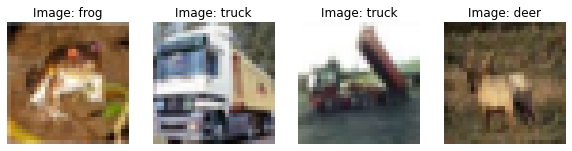

In [15]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, X_train, y_train):
    ax.set_axis_off()
    ax.imshow(image)
    ax.set_title(f'Image: {class_names[label]}')

In [16]:
# 24-bit color scale
print(f'Min. value of X_train: {X_train.min()}')
print(f'Max. value of X_train: {X_train.max()}\n')

print(f'Min. value of X_test: {X_train.min()}')
print(f'Max. value of X_test: {X_train.max()}')

Min. value of X_train: 0
Max. value of X_train: 255

Min. value of X_test: 0
Max. value of X_test: 255


#### 1.5 (Simple) Feature scaling
Since we are going to train the neural network using _Gradient Descent_, we must scale the **input features**. For simplicity, we’ll scale the pixel intensities down to the _0–1_ range by dividing them by **255.0** (8-bit gray image):

In [17]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [18]:
# rescaled 8-bit gray scale
print(f'Min. value of X_train: {X_train.min()}')
print(f'Max. value of X_train: {X_train.max()}\n')

print(f'Min. value of X_test: {X_test.min()}')
print(f'Max. value of X_test: {X_test.max()}')

Min. value of X_train: 0.0
Max. value of X_train: 1.0

Min. value of X_test: 0.0
Max. value of X_test: 1.0


## 2. Building and Training a CNN via Keras

### 2.1 Defining the Network Architecture
Proposed architecture for Multiclass Classification:
- INPUT [32x32x3]
- CONV [32, 4x4x3, 'valid']
- RELU
- MAX_POOL [2x2, stride=(2,2)]
- CONV [32, 4x4x32, 'valid']
- RELU
- MAX_POOL [2x2, stride=(2,2)]
- FLATTEN
- FC [256]
- RELU
- FC [10, 'softmax']


- optimizer: SGD with `learning_rate=0.05`
- kernel_initializer: "glorot_uniform"
- bias_initializer: "zeros"
- **No regularization**

#### **Defining the Network's Architecture**

In [19]:
print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')

X_train.shape: (50000, 32, 32, 3)
X_test.shape: (10000, 32, 32, 3)


In [21]:
input_shape = X_train.shape[1:]
input_shape

(32, 32, 3)

In [30]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def build_first_cnn():
    model = Sequential([
        Conv2D(filters=32, kernel_size=(4, 4), input_shape=input_shape, activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters=32, kernel_size=(4, 4), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        
        Flatten(),
        
        Dense(256, activation='relu'),
        Dense(10, activation='softmax')
    ])
    
    return model


In [31]:
model = build_first_cnn()

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 29, 29, 32)        1568      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 32)        16416     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 800)               0         
                                                                 
 dense_4 (Dense)             (None, 256)              

### Visualizing the Architecture

#### Native Keras Function: `plot_model`
https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model

Requirements:
- `graphviz` software for graph visualization
  + `sudo apt-get install graphviz`
  + `pip install graphviz`
- `pip install pydot`

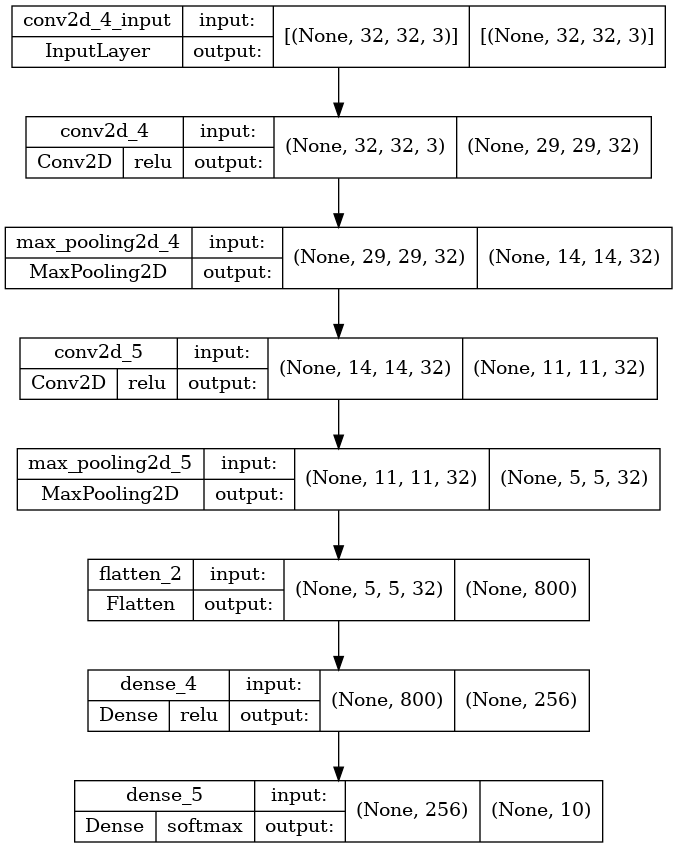

In [33]:
from tensorflow.keras.utils import plot_model
# vertical
plot_model(model, show_shapes=True, show_layer_activations=True)

#### visualkeras
https://github.com/paulgavrikov/visualkeras <br/>
https://analyticsindiamag.com/how-to-visualize-deep-learning-models-using-visualkeras/#:~:text=Visualkeras%20is%20a%20python%20package,style%20architecture%20of%20neural%20networks.

More indicated for Deep Neural Networks, especially CNNs.

Requirements:
- `pip install visualkeras`

In [34]:
import visualkeras

In [35]:
visualkeras.layered_view(model, legend=True, scale_z=1).show() # display using your system viewer

### 2.2 Compiling: Defining the Loss Function, Optimizer, and Metrics

#### **Loss:**

- `'binary_crossentropy'`: _binary classification_
    + E.g.: One or more binary labels, _sigmoid_ as activation function.
- `'categorical_crossentropy'`: _multiclass classification_, classes as **one-hot vectors**
    + E.g.: [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.] to represent class 3 out of 10 classes
- `'sparse_categorical_crossentropy'`: _multiclass classification_, classes as **sparse labels**:
    + E.g.: 1, 2, 3, ..., 9, 10


In [38]:
# https://keras.io/api/optimizers/sgd/
from tensorflow.keras.optimizers import SGD
opt = SGD(learning_rate=0.05)

model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

In [39]:
model.layers

### 2.3 Training

In case of GPU drivers, we can monitor its use by [_gpustat_](https://github.com/wookayin/gpustat).

On terminal, use: `gpustat -cpi`


In [40]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
1250/1250 [==============================] - 4s 3ms/step - loss: 1.7844 - accuracy: 0.3542 - val_loss: 1.4913 - val_accuracy: 0.4665
Epoch 2/30
1250/1250 [==============================] - 3s 2ms/step - loss: 1.3925 - accuracy: 0.5002 - val_loss: 1.3489 - val_accuracy: 0.5299
Epoch 3/30
1250/1250 [==============================] - 3s 2ms/step - loss: 1.2281 - accuracy: 0.5632 - val_loss: 1.2078 - val_accuracy: 0.5788
Epoch 4/30
1250/1250 [==============================] - 3s 2ms/step - loss: 1.1134 - accuracy: 0.6083 - val_loss: 1.1345 - val_accuracy: 0.6079
Epoch 5/30
1250/1250 [==============================] - 3s 2ms/step - loss: 1.0122 - accuracy: 0.6436 - val_loss: 1.1193 - val_accuracy: 0.6136
Epoch 6/30
1250/1250 [==============================] - 3s 2ms/step - loss: 0.9305 - accuracy: 0.6759 - val_loss: 1.0989 - val_accuracy: 0.6211
Epoch 7/30
1250/1250 [==============================] - 3s 2ms/step - loss: 0.8469 - accuracy: 0.7045 - val_loss: 1.0467 - val_accuracy:

#### **Visualizing the training history**

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)
history_df

,loss,accuracy,val_loss,val_accuracy
0,1.784404,0.354225,1.491316,0.4665
1,1.392548,0.500225,1.348889,0.5299
2,1.228142,0.563175,1.207756,0.5788
3,1.113401,0.608300,1.134540,0.6079
4,1.012152,0.643650,1.119256,0.6136
5,0.930486,0.675925,1.098902,0.6211
6,0.846863,0.704450,1.046736,0.6491
7,0.766053,0.732000,1.092804,0.6386
8,0.689392,0.759350,1.159567,0.6280
9,0.615945,0.784400,1.150094,0.6407


Text(0, 0.5, 'Score')

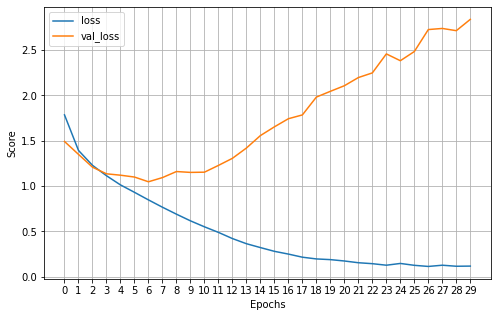

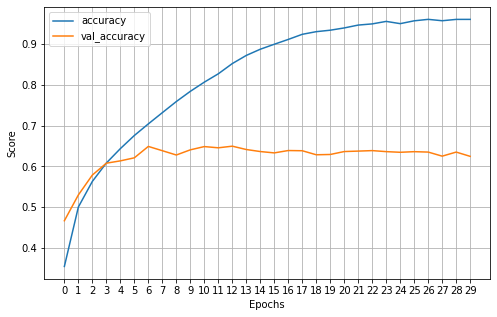

In [42]:
history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
plt.xticks(range(30))
plt.xlabel('Epochs')
plt.ylabel('Score')

history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
plt.xticks(range(30))
plt.xlabel('Epochs')
plt.ylabel('Score')

These plots give us some insight to the _training process_.  <br/>
Our _training_ and _testing loss/accuracy_ start to **diverge** significantly past ***epoch 6***, which implies that our network is modeling the _training data_ **too closely** and ***overfitting***. <br/>
This can be attributed to _a larger learning rate_ and the fact we **aren’t** using methods to help **combat overfitting**.

Some strategies to _remedy_ this issue include:
- changing the _learning rate_
- using some regularization technique:
    - L1
    - L2
    - _Dropout_
    - **Early Stopping**
- obtaining _more data_
- applying _data augmentation_

We'll see more details about these strategies soon!

#### **Effects of Learning Rates**
<img src='./figs/effects_of_learning_rates.png' width=500/>

Source: Rosebrock, Adrian. Deep learning for computer vision with python: starter bundle. PyImageSearch, 2017.

## 3. Evaluating and Predicting New Samples by using our Overfitted Model

#### **Evaluation**
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#evaluate

In [43]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 2.8372 - accuracy: 0.6196


[2.8372080326080322, 0.6195999979972839]

#### **Prediction**
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#predict

In [46]:
y_test_proba = model.predict(X_test)
y_test_proba

array([[9.9090123e-01, 1.2243913e-07, 1.1255306e-05, ..., 5.9379879e-10,
        8.0933981e-03, 4.9373152e-04],
       [1.0466338e-08, 9.7970426e-01, 6.3334531e-19, ..., 4.8368316e-21,
        2.0295722e-02, 1.1326204e-08],
       [4.6665579e-02, 7.8834318e-02, 1.4578145e-09, ..., 1.0366898e-06,
        8.7436199e-01, 1.3711637e-04],
       ...,
       [1.4242402e-13, 1.4534656e-15, 2.2878761e-04, ..., 1.9988553e-03,
        4.2243136e-11, 1.9065286e-08],
       [3.6127028e-09, 5.1366264e-05, 1.1262575e-09, ..., 1.3592175e-06,
        2.2957780e-09, 3.7003847e-10],
       [2.8595799e-22, 6.9112338e-21, 8.1472976e-16, ..., 1.0000000e+00,
        1.0647864e-16, 5.1190424e-18]], dtype=float32)

#### **Class Prediction**
https://stackoverflow.com/a/69503180/7069696

In [47]:
y_test_pred = np.argmax(y_test_proba, axis=1)
y_test_pred

array([0, 1, 8, ..., 5, 4, 7])

In [48]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred, target_names=[name for name in class_names]))

              precision    recall  f1-score   support

    airplane       0.64      0.69      0.66      1000
  automobile       0.70      0.76      0.73      1000
        bird       0.52      0.52      0.52      1000
         cat       0.45      0.38      0.41      1000
        deer       0.59      0.54      0.57      1000
         dog       0.55      0.48      0.51      1000
        frog       0.72      0.66      0.69      1000
       horse       0.63      0.70      0.66      1000
        ship       0.67      0.78      0.72      1000
       truck       0.67      0.69      0.68      1000

    accuracy                           0.62     10000
   macro avg       0.61      0.62      0.62     10000
weighted avg       0.61      0.62      0.62     10000



We got a **poor accuracy** of 62%.

## 4. Model Regularization by Early Stopping

A very different way to **regularize** _iterative learning algorithms_, such as _Gradient Descent_, is **to stop training** as soon as the _validation error_ reaches a **minimum**. This is called **early stopping**.


<img src='./figs/early_stopping.png' width=500>

Source: https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd

As the _epochs_ go by the algorithm learns, and its **prediction error** on the _training set_ goes down, along with its **prediction error** on the _validation set_. <br/>
After a while though, the _validation error_ stops **decreasing** and starts to **go back up**. <br/>
This indicates that the model has _started to **overfit the training data**_.

With **early stopping** we just ***stop*** _training_ as soon as the **validation error** reaches the _minimum_ (or after a _number of epochs_ **with no improvement**).

### ***Back to our model***

Text(0, 0.5, 'Score')

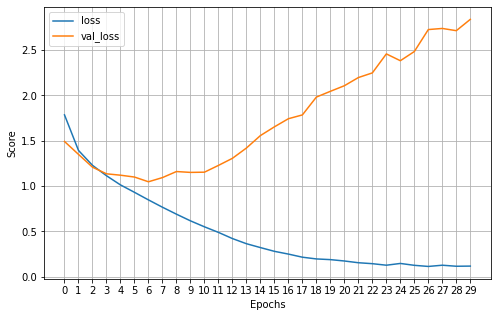

In [50]:
history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
plt.xticks(range(30))
plt.xlabel('Epochs')
plt.ylabel('Score')

Apparently, our **early stopping point** is the ***epoch 6***. <br/>
So, we should get the _trained model_ (_learned weights and biases_) at **this epoch**. However, our _final trained model_ is the one past 30 epochs.

### **Strategy 1**
One possible strategy to get there is to **retrain** our model ***from scratch***, but now with _just_ ***X + 1 epochs*** (PS: the epochs start at 0). <br/>
We need to _reset_ our _model weights_ and _biases_ before calling another `fit()`, otherwise Keras will keep training from the _learned weights and biases_ from the first `fit()` with 30 epochs.

In [51]:
# creating a new model with new initial weights and biases
model = build_first_cnn()

opt = tf.keras.optimizers.SGD(learning_rate=0.05)  # just for testing
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [52]:
history = model.fit(X_train, y_train, epochs=7, batch_size=32, validation_split=0.2)

Epoch 1/7
1250/1250 [==============================] - 3s 3ms/step - loss: 1.7678 - accuracy: 0.3597 - val_loss: 1.4689 - val_accuracy: 0.4700
Epoch 2/7
1250/1250 [==============================] - 3s 2ms/step - loss: 1.3689 - accuracy: 0.5117 - val_loss: 1.3003 - val_accuracy: 0.5459
Epoch 3/7
1250/1250 [==============================] - 3s 2ms/step - loss: 1.1972 - accuracy: 0.5790 - val_loss: 1.1657 - val_accuracy: 0.5862
Epoch 4/7
1250/1250 [==============================] - 3s 2ms/step - loss: 1.0798 - accuracy: 0.6197 - val_loss: 1.1137 - val_accuracy: 0.6171
Epoch 5/7
1250/1250 [==============================] - 3s 2ms/step - loss: 0.9786 - accuracy: 0.6587 - val_loss: 1.0839 - val_accuracy: 0.6261
Epoch 6/7
1250/1250 [==============================] - 3s 2ms/step - loss: 0.8890 - accuracy: 0.6873 - val_loss: 1.0767 - val_accuracy: 0.6311
Epoch 7/7
1250/1250 [==============================] - 3s 2ms/step - loss: 0.8098 - accuracy: 0.7181 - val_loss: 1.0838 - val_accuracy: 0.6339

Text(0, 0.5, 'Score')

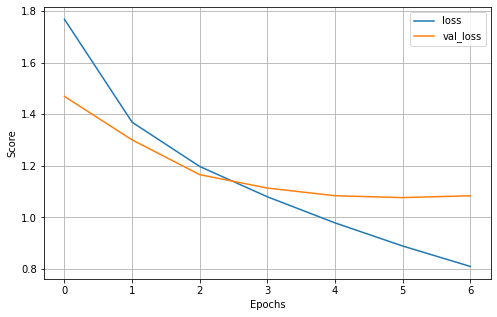

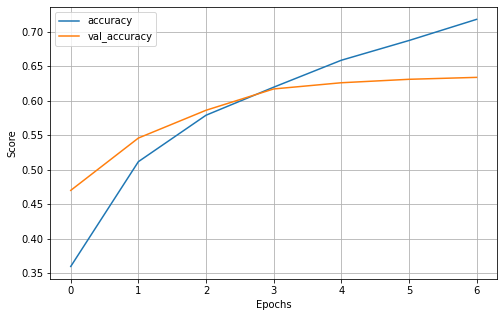

In [53]:
history_df = pd.DataFrame(history.history)

history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
plt.xticks(range(7))
plt.xlabel('Epochs')
plt.ylabel('Score')

history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
plt.xticks(range(7))
plt.xlabel('Epochs')
plt.ylabel('Score')

### **Strategy 2 - Keras Callbacks**
The `fit()` method accepts a **callbacks argument** that lets you specify a list of objects that Keras will _call_ at the _start_ and _end_ of _training_, at the _start_ and _end_ of _each epoch_, and even _before_ and _after processing each batch_.

One of this callbacks is `EarlyStopping`: https://keras.io/api/callbacks/early_stopping/

In [55]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_cb = EarlyStopping(patience=3, restore_best_weights=True)

We've just created an **early stopping callback** that will **interrupt** _training_ when it _measures_ **no progress** (no improvement) after 3 epochs (parameter `patience`) on the losso from the **validation set** (default parameter `monitor="val_loss"`).

We can now **retrain** our model from _scratch_ again, with **a large number of epochs**, since _training_ will **stop _automatically_** when _there is no more progress_. `EarlyStopping callback` will keep track of the **best weights** and _restore them_ for you at the _end of training_ (parameter `restore_best_weights=True)`).

In [56]:
# creating a new model with new initial weights and biases
model = build_first_cnn()

opt = tf.keras.optimizers.SGD(learning_rate=0.05)  # just for testing
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [57]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[early_stopping_cb])

Epoch 1/30
1250/1250 [==============================] - 3s 3ms/step - loss: 1.8098 - accuracy: 0.3453 - val_loss: 1.5137 - val_accuracy: 0.4615
Epoch 2/30
1250/1250 [==============================] - 3s 2ms/step - loss: 1.4090 - accuracy: 0.4929 - val_loss: 1.3279 - val_accuracy: 0.5346
Epoch 3/30
1250/1250 [==============================] - 3s 2ms/step - loss: 1.2451 - accuracy: 0.5588 - val_loss: 1.2045 - val_accuracy: 0.5746
Epoch 4/30
1250/1250 [==============================] - 3s 2ms/step - loss: 1.1219 - accuracy: 0.6010 - val_loss: 1.1978 - val_accuracy: 0.5918
Epoch 5/30
1250/1250 [==============================] - 3s 2ms/step - loss: 1.0194 - accuracy: 0.6416 - val_loss: 1.1210 - val_accuracy: 0.6213
Epoch 6/30
1250/1250 [==============================] - 3s 3ms/step - loss: 0.9329 - accuracy: 0.6733 - val_loss: 1.0948 - val_accuracy: 0.6262
Epoch 7/30
1250/1250 [==============================] - 3s 2ms/step - loss: 0.8540 - accuracy: 0.7002 - val_loss: 1.1805 - val_accuracy:

Text(0, 0.5, 'Score')

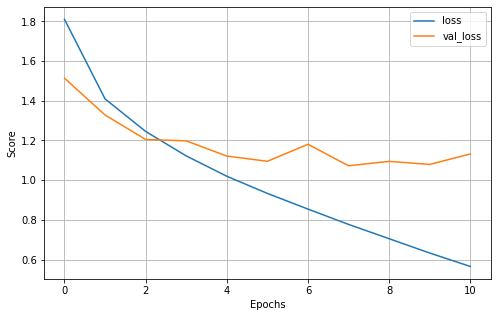

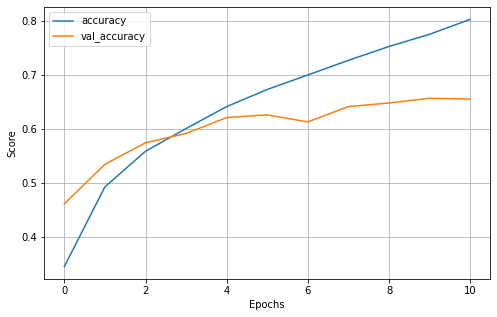

In [59]:
history_df = pd.DataFrame(history.history)

history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Score')

history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Score')

##### **More about Keras callbacks**
https://keras.io/api/callbacks/

## 5. Evaluating and Predicting New Samples with the Regularized model

#### **Evaluation**
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#evaluate

In [60]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.0810 - accuracy: 0.6383


[1.0809539556503296, 0.6383000016212463]

#### **Prediction**
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#predict

In [61]:
y_test_proba = model.predict(X_test)
y_test_proba

array([[9.5254660e-02, 2.2352522e-02, 1.5311223e-02, ..., 1.4585398e-02,
        8.8627562e-02, 1.4729592e-02],
       [3.9582182e-02, 9.1185950e-02, 4.2193537e-06, ..., 2.0727092e-07,
        8.5097700e-01, 1.8249186e-02],
       [2.4087589e-02, 2.0644803e-01, 2.2183690e-04, ..., 8.1849220e-04,
        5.9054089e-01, 1.7565773e-01],
       ...,
       [1.6727857e-06, 5.6440558e-07, 8.6164407e-02, ..., 1.9142503e-03,
        1.3482101e-04, 4.4805856e-05],
       [7.7968291e-03, 9.3129569e-01, 1.4551493e-04, ..., 2.8940759e-04,
        1.8784399e-03, 8.6619944e-04],
       [2.1849378e-06, 8.2406168e-06, 1.2495719e-04, ..., 9.6900302e-01,
        1.4593352e-06, 3.5418125e-06]], dtype=float32)

#### **Class Prediction**
https://stackoverflow.com/a/69503180/7069696

In [62]:
y_test_pred = np.argmax(y_test_proba, axis=1)
y_test_pred

array([3, 8, 8, ..., 5, 1, 7])

In [63]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred, target_names=[name for name in class_names]))

              precision    recall  f1-score   support

    airplane       0.75      0.60      0.67      1000
  automobile       0.75      0.77      0.76      1000
        bird       0.50      0.56      0.53      1000
         cat       0.49      0.36      0.42      1000
        deer       0.53      0.69      0.60      1000
         dog       0.53      0.54      0.54      1000
        frog       0.75      0.69      0.72      1000
       horse       0.74      0.64      0.69      1000
        ship       0.71      0.78      0.74      1000
       truck       0.67      0.75      0.71      1000

    accuracy                           0.64     10000
   macro avg       0.64      0.64      0.64     10000
weighted avg       0.64      0.64      0.64     10000



The resulting _accuracy_ on the **testing set** keeps **poor** but slightly better than using the overfitted model.

# Exercise

Repeat the experiments considering different:
-  values for _learning_rate_ of SGD
- optimizers (e.g., 'nadam')
- kernel regularizer (e.g., 'l2')